<a href="https://colab.research.google.com/github/Morinocox/Price_Prediction/blob/main/Price_Predicion_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This is the project presented to pass the Data Science course at Digital House
### I first import all libraries I'll need

---



In [15]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras.models import Sequential
from keras.models import Model
from keras import optimizers
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras import optimizers
import numpy as np
# libraries for the files in google drive
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [16]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '1RsUW_-fytyC8NMWDAEaizNOaZSW1zdy-' #<-- This is the file id, which i find in almost in the midle of the sharable link. 

download = drive.CreateFile({'id': file_id})

# Downloading the file
download.GetContentFile('AMZN_dataset.csv')
df  = pd.read_csv("AMZN_dataset.csv")
df.head()

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/__init__.py", line 44, in autodetect
    from . import file_cache
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 41, in <module>
    "file_cach

,Date,Open,High,Low,Close,Volume
0,5/18/2012 16:00:00,219.45,219.63,212.81,213.85,5233522
1,5/21/2012 16:00:00,214.03,219.98,212.82,218.11,3580096
2,5/22/2012 16:00:00,218.00,218.87,213.96,215.33,3733844
3,5/23/2012 16:00:00,214.18,217.55,211.18,217.28,4243774
4,5/24/2012 16:00:00,216.76,217.66,212.70,215.24,3141496


In [17]:
data=df
data

,Date,Open,High,Low,Close,Volume
0,5/18/2012 16:00:00,219.45,219.63,212.81,213.85,5233522
1,5/21/2012 16:00:00,214.03,219.98,212.82,218.11,3580096
2,5/22/2012 16:00:00,218.00,218.87,213.96,215.33,3733844
3,5/23/2012 16:00:00,214.18,217.55,211.18,217.28,4243774
4,5/24/2012 16:00:00,216.76,217.66,212.70,215.24,3141496
...,...,...,...,...,...,...
2289,6/24/2021 16:00:00,3507.64,3524.86,3430.85,3449.08,3831999
2290,6/25/2021 16:00:00,3464.00,3464.82,3394.18,3401.46,3940997
2291,6/28/2021 16:00:00,3416.00,3448.00,3413.51,3443.89,2242793
2292,6/29/2021 16:00:00,3438.82,3456.03,3423.03,3448.14,2098439


In [18]:
def csv_to_dataset(csv_path):
  datos = pd.read_csv(csv_path)
  
  # borra el primer día
  datos  = datos.drop(0, axis=0)
  print('Datos: ', datos.head(), '\n')
  
  #Ordena de más viejo a más reciente
  datos = datos.sort_values('Date')
  print('Datos por Fecha: ', datos.head(),'\n')
  
  #Borra la columna Fecha
  datos = datos.drop('Date', axis=1)

  
  normalizador = preprocessing.MinMaxScaler()
  datos_norm = normalizador.fit_transform(datos)

  print("Datos Normalizados", datos_norm[:10],'\n')

  # X
  ohlcv_histories_normalised = np.array([datos_norm[i  : i + historic_points].copy() for i in range(len(datos_norm) - historic_points)])

  # y
  next_day_open_values_normalised = np.array([datos_norm[:,0][i + historic_points].copy() for i in range(len(datos_norm) - historic_points)])

  next_day_open_values = np.array([datos.iloc[:,0][i + historic_points].copy() for i in range(len(datos) - historic_points)])
  next_day_open_values = np.expand_dims(next_day_open_values_normalised, -1)
  
  y_scaler = preprocessing.MinMaxScaler()
  y_scaler.fit(next_day_open_values)

  # Indicador técnicos
  technical_indicators = []

  for his in ohlcv_histories_normalised:
    #Promedio del precio de cierre Slow Moving Average
    sma = np.mean(his[:,3])
    technical_indicators.append(np.array([sma]))
  
  technical_indicators = np.array(technical_indicators)
  tech_ind_scaler = preprocessing.MinMaxScaler()
  technical_indicators_normalised = tech_ind_scaler.fit_transform(technical_indicators)
  
  
  assert ohlcv_histories_normalised.shape[0] == next_day_open_values_normalised.shape[0] == technical_indicators_normalised.shape[0]

  return ohlcv_histories_normalised, technical_indicators_normalised, next_day_open_values_normalised, next_day_open_values, y_scaler

In [19]:
ohlcv_histories, technical_indicators, next_day_open_values, unscaled_y, y_scaler = csv_to_dataset(path)

Datos:           Date        Open        High         Low       Close   Adj Close  \
1  2016-09-13  768.770020  769.890015  759.049988  761.010010  761.010010   
2  2016-09-14  762.200012  767.500000  758.849976  761.090027  761.090027   
3  2016-09-15  762.000000  770.869995  757.580017  769.690002  769.690002   
4  2016-09-16  773.280029  780.460022  771.659973  778.520020  778.520020   
5  2016-09-19  779.969971  781.940002  771.000000  775.099976  775.099976   

    Volume  
1  3117200  
2  2523000  
3  3034000  
4  5499200  
5  2297200   

Datos por Fecha:           Date        Open        High         Low       Close   Adj Close  \
1  2016-09-13  768.770020  769.890015  759.049988  761.010010  761.010010   
2  2016-09-14  762.200012  767.500000  758.849976  761.090027  761.090027   
3  2016-09-15  762.000000  770.869995  757.580017  769.690002  769.690002   
4  2016-09-16  773.280029  780.460022  771.659973  778.520020  778.520020   
5  2016-09-19  779.969971  781.940002  771.000

In [20]:
test_split = 0.70
n = int(ohlcv_histories.shape[0] * test_split)

ohlcv_train = ohlcv_histories[:n]
tech_ind_train = technical_indicators[:n]
y_train = next_day_open_values[:n]

ohlcv_test = ohlcv_histories[n:]
tech_ind_test = technical_indicators[n:]
y_test = next_day_open_values[n:]

unscaled_y_test = unscaled_y[n:]

In [21]:
n

879

In [22]:
# definimos los dos sets de inputs
lstm_input = Input(shape=(historic_points, 6), name='lstm_input')
dense_input = Input(shape=(technical_indicators.shape[1],), name='tech_input')
 
# la primera capa utiliza el primer input
x = LSTM(50, name='lstm_0')(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
lstm_branch = Model(inputs=lstm_input, outputs=x)
 
# la segunda capa utiliza el segundo input
y = Dense(20, name='tech_dense_0')(dense_input)
y = Activation("relu", name='tech_relu_0')(y)
y = Dropout(0.2, name='tech_dropout_0')(y)
technical_indicators_branch = Model(inputs=dense_input, outputs=y)
 
# combine the output of the two branches
combined = concatenate([lstm_branch.output, technical_indicators_branch.output], name='concatenate')
 
z = Dense(64, activation="sigmoid", name='dense_pooling')(combined)
z = Dense(1, activation="linear", name='dense_out')(z)
 
# El modelo usara las dos capaz creadas
model = Model(inputs=[lstm_branch.input, technical_indicators_branch.input], outputs=z)

model.compile(optimizer='adam', loss='mse', metrics=['accuracy', 'mae', 'mse', 'mape'])

In [23]:
ohlcv_train.shape

(879, 1, 6)

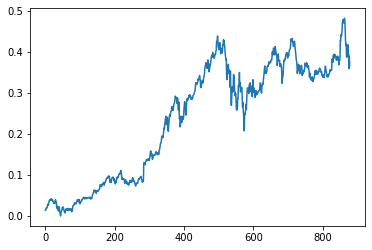

In [24]:
plt.plot(tech_ind_train)

In [25]:
y_train.shape

(879,)

In [26]:
model.fit(x=[ohlcv_train, tech_ind_train], y=y_train, batch_size=32, verbose=0, epochs=50, shuffle=True, validation_split=0.1)

In [27]:
# Desnormalizamos las predicciones que están normalizadas
y_test_predicted = model.predict([ohlcv_test, tech_ind_test])

y_test_predicted = y_scaler.inverse_transform(y_test_predicted)

real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
print(scaled_mse)

0.2625054722821857


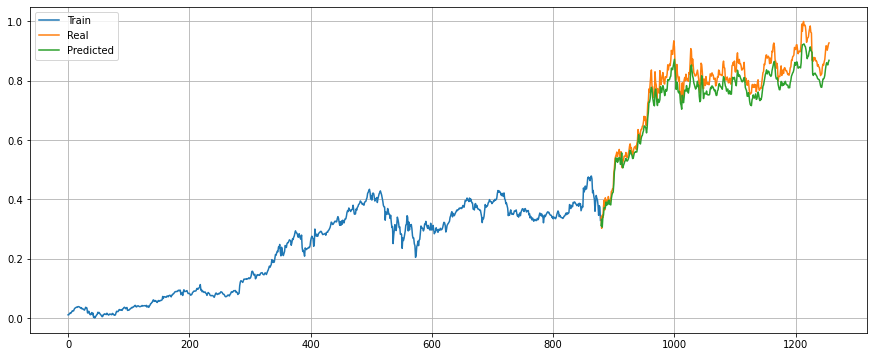

In [28]:
plt.gcf().set_size_inches(15, 6, forward=True)


yt=plt.plot(y_train, label='train')
real = plt.plot(np.arange(len(y_train),len(y_train)+len( unscaled_y_test)), unscaled_y_test, label='real')
pred = plt.plot(np.arange(len(y_train),len(y_train)+len( unscaled_y_test)),y_test_predicted, label='predicted')

plt.legend(['Train','Real', 'Predicted'])
plt.grid(True)
plt.show()